In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data Fetch

In [2]:
expedia = pd.read_csv("data/train.csv")

In [3]:
expedia.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
df = expedia.loc[expedia['prop_id']==104517]

In [5]:
df = df.loc[df['srch_room_count']==1]
df = df.loc[df['visitor_location_country_id']==219]
#df = df[['date_time','price_usd','srch_booking_window','srch_saturday_night_bool']]

In [6]:
# 查看各个字段的IV值
# caculate iv and generate a df with iv sorted in a descending order, which can be used for feature selection
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3
# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0#！
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    # 
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    iv.sort_values('IV',ascending=False,inplace=True)
    iv_df.sort_values('IV',ascending=False,inplace=True)
    return(iv_df,iv)


In [7]:
no_id = df.columns.drop('price_usd')
iv_df, iv = data_vars(df[no_id],df['price_usd'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting becau

In [8]:
iv.head(20)

,VAR_NAME,IV
26,date_time,2.042086e-05
49,srch_saturday_night_bool,2.834263e-06
25,comp8_rate_percent_diff,1.282218e-06
16,comp5_rate_percent_diff,8.402076e-07
10,comp3_rate_percent_diff,7.492466e-07
27,gross_bookings_usd,4.674011e-07
36,prop_log_historical_price,4.374013e-07
7,comp2_rate_percent_diff,3.827852e-07
23,comp8_inv,3.053488e-07
5,comp2_inv,3.002613e-07


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2041 to 9917395
Data columns (total 4 columns):
date_time                   3049 non-null object
price_usd                   3049 non-null float64
srch_booking_window         3049 non-null int64
srch_saturday_night_bool    3049 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


In [66]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df['price_usd'].describe()

count   3049.000
mean     112.939
std      113.374
min        0.120
25%       67.000
50%      100.000
75%      141.000
max     5584.000
Name: price_usd, dtype: float64

In [14]:
# point anomalies
expedia.loc[(expedia['price_usd']==5584) & (expedia['visitor_location_country_id']==219)]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
2905344,195154,2013-04-07 20:59:07,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,28.0,0,NaN,0


In [67]:
df = df.loc[df['price_usd']<5584]

In [68]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2041,2013-03-14 11:27:28,206.000,99,1
3152,2013-01-03 20:48:24,186.000,6,0
5166,2013-01-19 16:51:27,61.000,1,0
10135,2013-01-26 11:34:23,72.000,116,0
10560,2013-04-29 09:39:50,246.000,245,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3048 entries, 2041 to 9917395
Data columns (total 4 columns):
date_time                   3048 non-null object
price_usd                   3048 non-null float64
srch_booking_window         3048 non-null int64
srch_saturday_night_bool    3048 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


In [69]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
df['price_usd'].describe()

count   3048.000
mean     111.144
std       55.055
min        0.120
25%       67.000
50%      100.000
75%      141.000
max      536.000
Name: price_usd, dtype: float64

## Time Series Viz

Text(0.5, 1.0, 'Time Series of room price by date time of search')

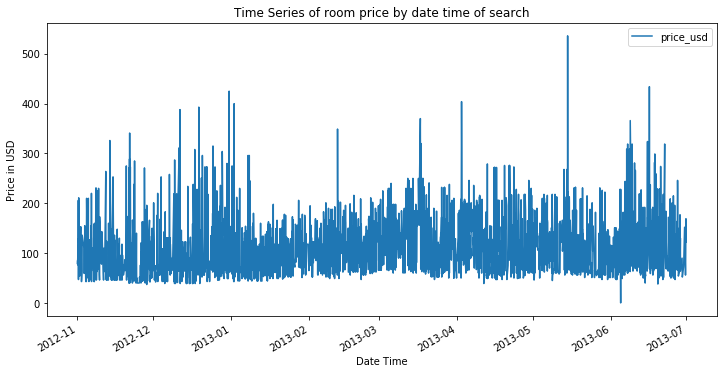

In [70]:
df.plot(x='date_time',y='price_usd',figsize=(12,6))
plt.xlabel('Date Time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search')

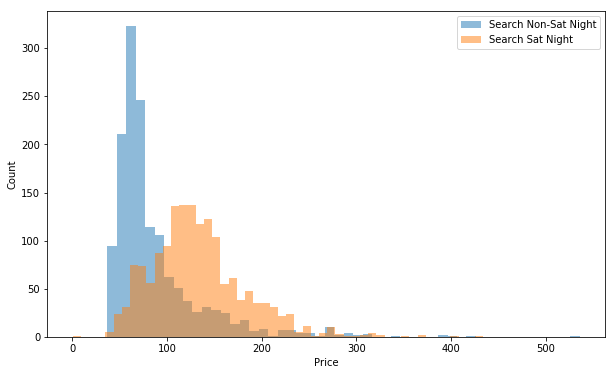

In [71]:
a = df.loc[df['srch_saturday_night_bool']==0,'price_usd']
b = df.loc[df['srch_saturday_night_bool']==1,'price_usd']
plt.figure(figsize=(10,6))
plt.hist(a,bins=50,alpha=0.5,label='Search Non-Sat Night')
plt.hist(b,bins=50,alpha=0.5,label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

In [72]:
df['srch_saturday_night_bool'].value_counts()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64

## Clustering-Based Anomaly Detection

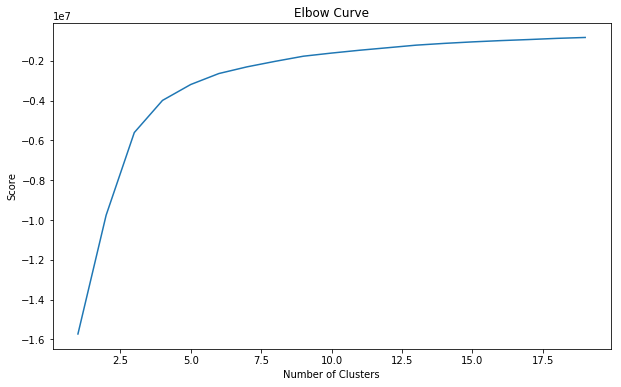

In [73]:
data = df[['price_usd','srch_booking_window','srch_saturday_night_bool']]
n_cluster = range(1,20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster,scores)
plt.xlabel("Number of Clusters")
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

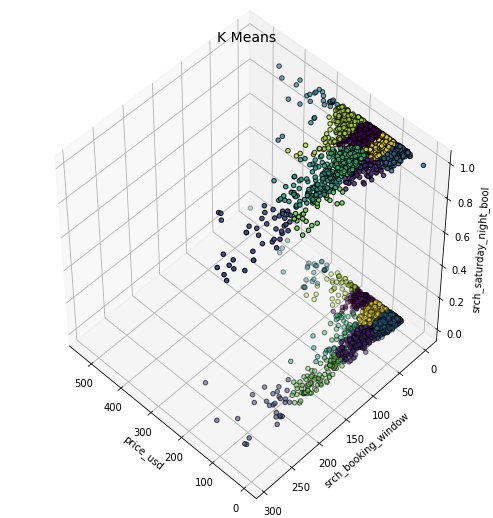

In [74]:
X = df[['price_usd','srch_booking_window','srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
# plotting
fig = plt.figure(1,figsize=(7,7))
ax = Axes3D(fig,rect=[0,0,0.95,1],elev=48,azim=134)
ax.scatter(X.iloc[:,0],X.iloc[:,1],X.iloc[:,2],
          c=labels.astype(np.float),edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

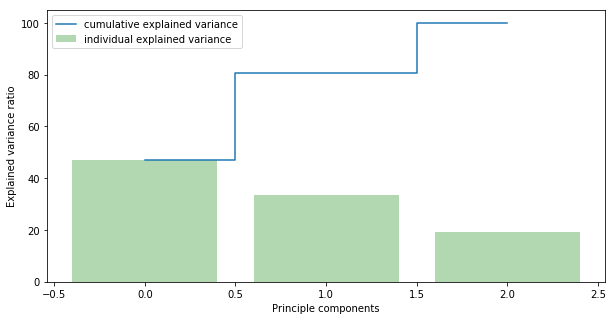

In [75]:
data = df[['price_usd','srch_booking_window','srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std,axis=0)
cov_mat = np.cov(X_std.T)
eig_vals,eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [np.abs(eig_vals[i],eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
tot=sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals,reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) #Cumulative explained variance

plt.figure(figsize=(10,5))
plt.bar(range(len(var_exp)),var_exp,alpha=0.3,align='center',label='individual explained variance', color='g')
plt.step(range(len(cum_var_exp)), cum_var_exp,where='mid',label='cumulative explained variance')
plt.ylabel("Explained variance ratio")
plt.xlabel("Principle components")
plt.legend(loc="best")
plt.show();

In [76]:
# Take useful feature and standardize them
data = df[['price_usd','srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [77]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principle_feature1'] = data[0]
df['principle_feature2'] = data[1]
df['cluster'].value_counts()

0    663
1    592
4    429
7    354
9    353
6    212
5    151
2    149
3     79
8     66
Name: cluster, dtype: int64

In [78]:
df.head(2)

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principle_feature1,principle_feature2
0,2012-11-01 02:48:30,84.000,19,0,0,-0.890,-0.522
1,2012-11-01 03:06:43,78.000,16,1,4,0.231,-0.272


In [79]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


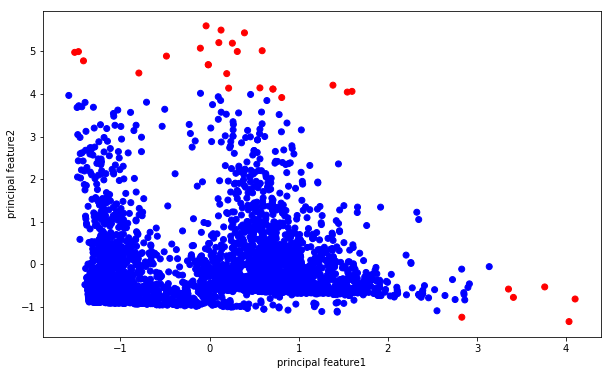

In [82]:
# viz of anomaly with clsuter view
fig,ax = plt.subplots(figsize=(10,6))
colors  = {0:'blue',1:'red'}
ax.scatter(df['principle_feature1'],df['principle_feature2'],c=df['anomaly1'].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [83]:
df.anomaly1.value_counts()

0    3018
1      30
Name: anomaly1, dtype: int64

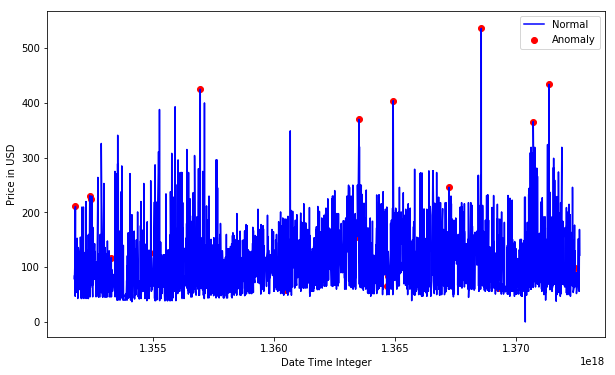

In [84]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig,ax=plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1']==1, ['date_time_int','price_usd']] # anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue',label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('Price in USD')
plt.legend()
plt.show();

In [85]:
df.head(2)

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principle_feature1,principle_feature2,anomaly1,date_time_int
0,2012-11-01 02:48:30,84.000,19,0,0,-0.890,-0.522,0,1351738110000000000
1,2012-11-01 03:06:43,78.000,16,1,4,0.231,-0.272,0,1351739203000000000


In [91]:
df.anomaly1.value_counts()

0    3018
1      30
Name: anomaly1, dtype: int64

#### viz of anomaly with re-partition

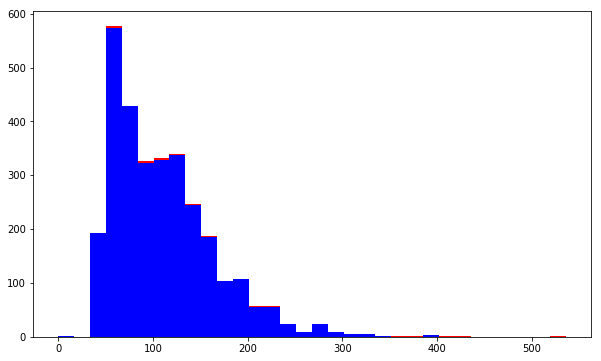

In [93]:
a = df.loc[df['anomaly1']==0,'price_usd']
b = df.loc[df['anomaly1']==1,'price_usd']

fig,axs = plt.subplots(figsize=(10,6))
axs.hist([a,b],bins=32,stacked=True,color=['blue','red'])
plt.show()

## Isolation Forest for anomaly detection.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


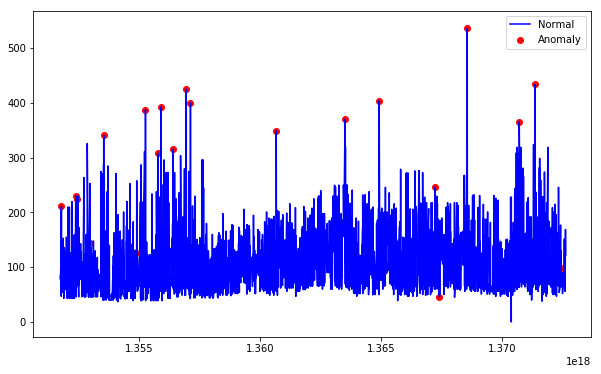

In [95]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
# https://zhuanlan.zhihu.com/p/25040651
data = df[['price_usd','srch_booking_window','srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly2'] = pd.Series(model.predict(data))

fig,ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly2']== -1, ['date_time_int','price_usd']]

ax.plot(df['date_time_int'],df['price_usd'],color='blue',label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'],color='red',label='Anomaly')
plt.legend()
plt.show();

In [96]:
df['anomaly2'].unique()

array([ 1, -1])

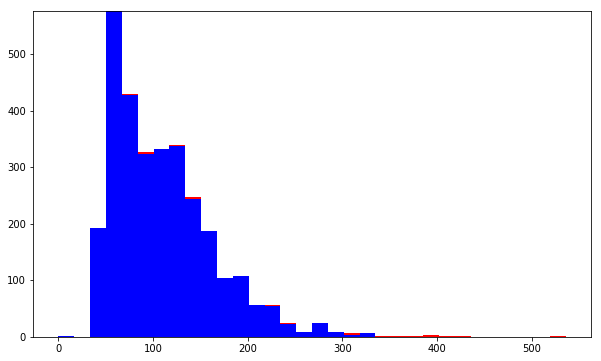

In [98]:
# viz of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1,'price_usd']
b = df.loc[df['anomaly2'] == -1,'price_usd']

fig,axs = plt.subplots(figsize=(10,6))
axs.hist([a,b],bins=32,stacked=True,color=['blue','red'])
plt.show();

## Support Vector Machine-Based Anomaly Detection

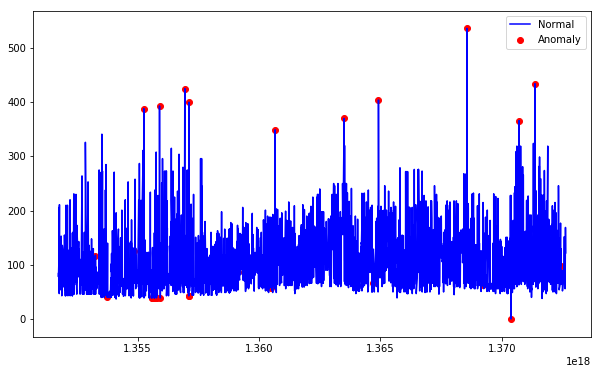

In [99]:
data = df[['price_usd','srch_booking_window','srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train one-class SVM
model = OneClassSVM(nu=outliers_fraction,kernel='rbf',gamma=0.01)
model.fit(data)

df['anomaly3'] = pd.Series(model.predict(data))
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly3']==-1,['date_time_int','price_usd']]

ax.plot(df['date_time_int'],df['price_usd'],color='blue',label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'],color='red',label='Anomaly')
plt.legend()
plt.show();

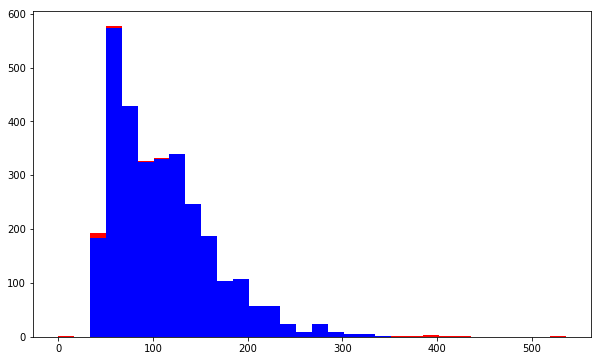

In [101]:
a = df.loc[df['anomaly3']==1,'price_usd']
b = df.loc[df['anomaly3']==-1,'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b],bins=32,stacked=True,color=['blue','red'])
plt.show();

## Anomaly Detection using Gaussian Distribution

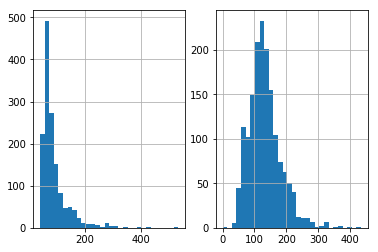

In [108]:
df_class0 = df.loc[df['srch_saturday_night_bool']==0,'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool']==1,'price_usd']

fig,axs = plt.subplots(1,2)
df_class0.hist(ax=axs[0],bins=30)
df_class1.hist(ax=axs[1],bins=30)

In [109]:
envelope = EllipticEnvelope(contamination=outliers_fraction)
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope = EllipticEnvelope(contamination=outliers_fraction)
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


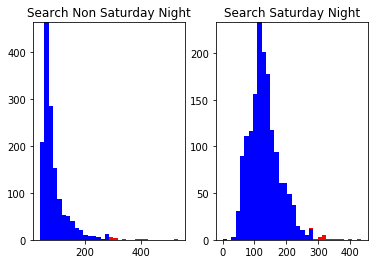

In [111]:
# plot the price repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_usd']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_usd']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'price_usd']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'price_usd']

fig,axs=plt.subplots(1,2)
axs[0].hist([a0,b0],bins=32,stacked=True, color=['blue','red'])
axs[1].hist([a2,b2],bins=32,stacked=True, color=['blue','red'])
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night")
plt.show();

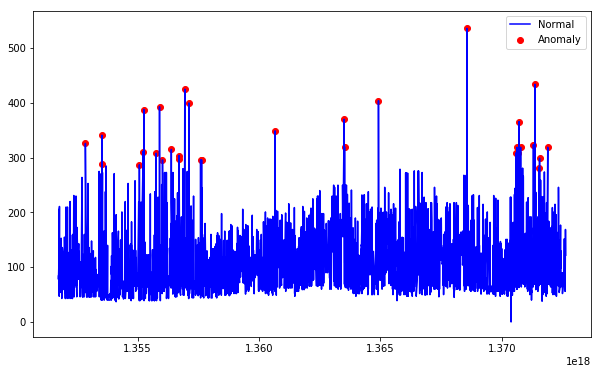

In [113]:
# add the data to the main
df_class = pd.concat([df_class0,df_class1])
df['anomaly5'] = df_class['anomaly']
fig,ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly5']==-1, ('date_time_int','price_usd')]
ax.plot(df['date_time_int'],df['price_usd'],color='blue',label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'],color='red',label='Anomaly')
plt.legend()
plt.show();

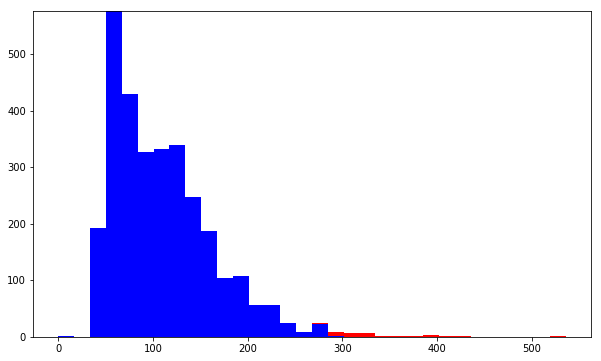

In [114]:
a = df.loc[df['anomaly5']==1,'price_usd']
b = df.loc[df['anomaly5']==-1,'price_usd']

fig,axs=plt.subplots(figsize=(10,6))
axs.hist([a,b],bins=32,stacked=True,color=['blue','red'])
plt.show();

## Markov Chain

In [124]:
from pyemma import msm
df['price_usd'].describe()

ModuleNotFoundError: No module named 'pyemma'

In [117]:
# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

# return the success probability of the state change 
def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0,len(transition_matrix)):
        if (k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

# return the success probability of the whole sequence
def sucessScore(sequence, transition_matrix):
    proba = 0 
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba

# return if the sequence is an anomaly considering a threshold
def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1

# return a dataframe containing anomaly result for the whole dataset 
# choosing a sliding windows size (size of sequence to evaluate) and a threshold
def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if j < windows_size:
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [122]:
from pyemma import msm

ModuleNotFoundError: No module named 'pyemma'